# Mongodb scratchpad

Sam Maurer, October 2018

Make sure to launch the mongodb server first:  
`mongod --dbpath ~/mongodb-data`

https://api.mongodb.com/python/current/api/pymongo/index.html  
https://docs.mongodb.com/manual/reference/operator/aggregation-pipeline/

In [1]:
import numpy as np
import pandas as pd
import pymongo

import datetime
import os

In [10]:
%matplotlib inline

### Mongo connection

In [2]:
client = pymongo.MongoClient()

In [3]:
db = client.tweets
col = db.westcoastmonthly
r1 = db.westcoast_monthly_random_10k
r2 = db.westcoast_monthly_random_1M

In [4]:
col.count_documents({})

18000000

### Mongo operations

In [5]:
col.find_one({})

{'_id': ObjectId('5bc7b5dc6bbd390c66cde84e'),
 'contributors': None,
 'truncated': False,
 'text': "I can't click on digital representations of video clips any more. 🔪📼🖱🚨",
 'is_quote_status': False,
 'in_reply_to_status_id': None,
 'id': 738194571331391489,
 'favorite_count': 0,
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'retweeted': False,
 'coordinates': None,
 'timestamp_ms': '1464834275454',
 'entities': {'user_mentions': [], 'symbols': [], 'hashtags': [], 'urls': []},
 'in_reply_to_screen_name': None,
 'id_str': '738194571331391489',
 'retweet_count': 0,
 'in_reply_to_user_id': None,
 'favorited': False,
 'user': {'follow_request_sent': None,
  'profile_use_background_image': True,
  'default_profile_image': False,
  'id': 18794420,
  'verified': False,
  'profile_image_url_https': 'https://pbs.twimg.com/profile_images/569268765926240256/_t9_8eIa_normal.png',
  'profile_sidebar_fill_color': '000000',
  'profile_text_color': '

In [25]:
%%time
c = col.aggregate([{"$group": {"_id": {"lang": "$lang"}, "count": {"$sum": 1}}}])
for doc in c:
    print(doc)

{'_id': {'lang': 'hr'}, 'count': 63}
{'_id': {'lang': 'sk'}, 'count': 136}
{'_id': {'lang': 'ca'}, 'count': 288}
{'_id': {'lang': 'lo'}, 'count': 5}
{'_id': {'lang': 'or'}, 'count': 94}
{'_id': {'lang': 'am'}, 'count': 57}
{'_id': {'lang': 'te'}, 'count': 9}
{'_id': {'lang': 'ml'}, 'count': 2}
{'_id': {'lang': 'kn'}, 'count': 42}
{'_id': {'lang': 'sd'}, 'count': 1}
{'_id': {'lang': 'bn'}, 'count': 14}
{'_id': {'lang': 'my'}, 'count': 12}
{'_id': {'lang': 'mr'}, 'count': 4}
{'_id': {'lang': 'hy'}, 'count': 25}
{'_id': {'lang': 'el'}, 'count': 72}
{'_id': {'lang': 'ta'}, 'count': 59}
{'_id': {'lang': 'pl'}, 'count': 6241}
{'_id': {'lang': 'sr'}, 'count': 76}
{'_id': {'lang': 'ne'}, 'count': 99}
{'_id': {'lang': 'nl'}, 'count': 8601}
{'_id': {'lang': 'ur'}, 'count': 408}
{'_id': {'lang': 'ko'}, 'count': 5390}
{'_id': {'lang': 'lt'}, 'count': 1935}
{'_id': {'lang': 'zh'}, 'count': 5304}
{'_id': {'lang': 'bg'}, 'count': 187}
{'_id': {'lang': 'is'}, 'count': 2048}
{'_id': {'lang': 'hu'}, 'co

In [56]:
%%time
c = list(col.aggregate([{"$sortByCount": "$lang"}, {"$limit": 10}]))

CPU times: user 48.9 ms, sys: 16.5 ms, total: 65.4 ms
Wall time: 4min


In [59]:
total = col.estimated_document_count()

for doc in c:
    print("{}: {} ({}%)".format(doc['_id'], doc['count'], round(100*doc['count']/total, 1)))

en: 15367971 (85.4%)
und: 1515231 (8.4%)
es: 397040 (2.2%)
tl: 116017 (0.6%)
fr: 69486 (0.4%)
pt: 60277 (0.3%)
in: 56202 (0.3%)
ja: 54375 (0.3%)
ht: 47763 (0.3%)
ar: 40893 (0.2%)


In [6]:
%%time
c = list(col.aggregate([
    {"$sample": {"size": 1000}}, 
    {"$sortByCount": "$lang"}, 
    {"$limit": 10}]))
print(c)

[{'_id': 'en', 'count': 846}, {'_id': 'und', 'count': 101}, {'_id': 'es', 'count': 19}, {'_id': 'tl', 'count': 8}, {'_id': 'ht', 'count': 7}, {'_id': 'pt', 'count': 4}, {'_id': 'ja', 'count': 3}, {'_id': 'ar', 'count': 2}, {'_id': 'it', 'count': 2}, {'_id': 'in', 'count': 2}]
CPU times: user 2.06 ms, sys: 1.26 ms, total: 3.32 ms
Wall time: 5.93 s


In [11]:
%%time
c = list(col.aggregate([
    {"$sample": {"size": 10000}}, 
    {"$out": "westcoast_monthly_random_10k"}]))
print(c)

[]
CPU times: user 2.08 ms, sys: 2.34 ms, total: 4.42 ms
Wall time: 3.6 s


In [15]:
db.list_collection_names()

['westcoastmonthly',
 'westcoast_monthly_random_10k',
 'westcoast_sample_random_10k']

In [16]:
db.drop_collection('westcoast_sample_random_10k')

{'ns': 'tweets.westcoast_sample_random_10k', 'nIndexesWas': 1, 'ok': 1.0}

In [39]:
%%time
c = list(col.aggregate([
    {"$sample": {"size": 1000000}}, 
    {"$out": "westcoast_monthly_random_1M"}],
    allowDiskUse = True))
print(c)

[]
CPU times: user 398 ms, sys: 133 ms, total: 531 ms
Wall time: 17min 57s


In [6]:
%%time
c = list(r1.aggregate([
    {"$sortByCount": "$lang"}, 
    {"$limit": 10}]))
print(c)

[{'_id': 'en', 'count': 8510}, {'_id': 'und', 'count': 832}, {'_id': 'es', 'count': 240}, {'_id': 'tl', 'count': 70}, {'_id': 'fr', 'count': 43}, {'_id': 'in', 'count': 35}, {'_id': 'pt', 'count': 31}, {'_id': 'ht', 'count': 28}, {'_id': 'ja', 'count': 27}, {'_id': 'ar', 'count': 26}]
CPU times: user 1.16 ms, sys: 900 µs, total: 2.06 ms
Wall time: 126 ms


In [7]:
%%time
c = list(r1.aggregate([
    {"$project": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$sortByCount": {"$year": "$_dt"}}]))
print(c)

[{'_id': 2016, 'count': 3396}, {'_id': 2017, 'count': 3304}, {'_id': 2018, 'count': 2573}, {'_id': 2015, 'count': 727}]
CPU times: user 1.47 ms, sys: 1.35 ms, total: 2.82 ms
Wall time: 39.6 ms


In [26]:
%%time
c = list(r1.aggregate([
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$limit": 1},
    {"$project": {"_dt": True}}]))
print(c)

[{'_id': ObjectId('5bc7c1a26bbd390c6672acd1'), '_dt': datetime.datetime(2016, 10, 2, 3, 14, 5, 255000)}]
CPU times: user 2.45 ms, sys: 1.19 ms, total: 3.64 ms
Wall time: 18.7 ms


In [8]:
%%time
c = list(r2.aggregate([
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "count": {"$sum": 1}}}]))
print(c[:2])

[{'_id': {'y': None, 'm': None}, 'count': 10}, {'_id': {'y': 2018, 'm': 2}, 'count': 27907}]
CPU times: user 5.06 ms, sys: 2.03 ms, total: 7.1 ms
Wall time: 18.7 s


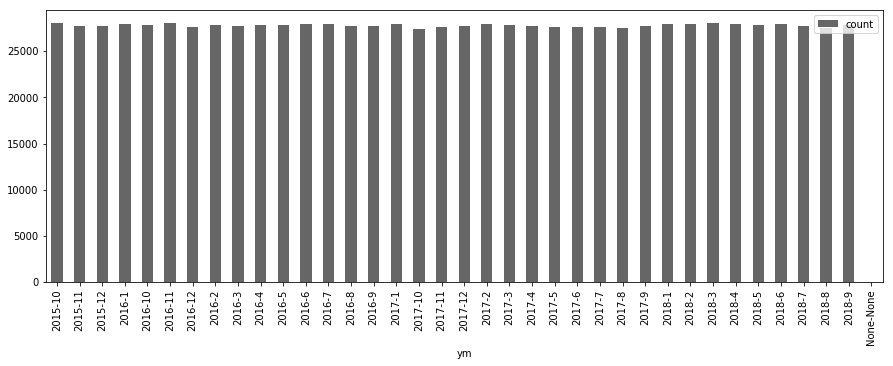

In [11]:
ym, count = ([], [])

for doc in c:
    ym.append(str(doc['_id']['y']) + '-' + str(doc['_id']['m']))
    count.append(doc['count'])

df = pd.DataFrame({'ym': ym, 'count': count}).sort_values('ym')
df.plot.bar(x='ym', y='count', figsize=(15,5), facecolor='666')

In [9]:
calif_bbox = {'type':'Polygon','coordinates': [[[-124.48, 42.01], [-124.48, 32.52],
[-114.13, 32.52], [-114.13, 42.01], [-124.48, 42.01]]]}

In [16]:
%%time
print(collection.count_documents({"coordinates": {"$geoWithin": {"$geometry": calif_bbox}}}))

504604
CPU times: user 5.42 ms, sys: 3.06 ms, total: 8.48 ms
Wall time: 24.4 s
